Using 404 features (aligned to training):
['id', 'channel_12', 'channel_14', 'channel_15', 'channel_16', 'channel_18', 'channel_19', 'channel_22', 'channel_26', 'channel_28', '...']
Saved 53 event detection records to /home/hajjohn1/bachelors-thesis/final/XGB/lag/eval_event_detection_xgb_model.json


/tmp/ipykernel_2116040/4185557450.py:121: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("length_bin", dropna=False)["detected"]


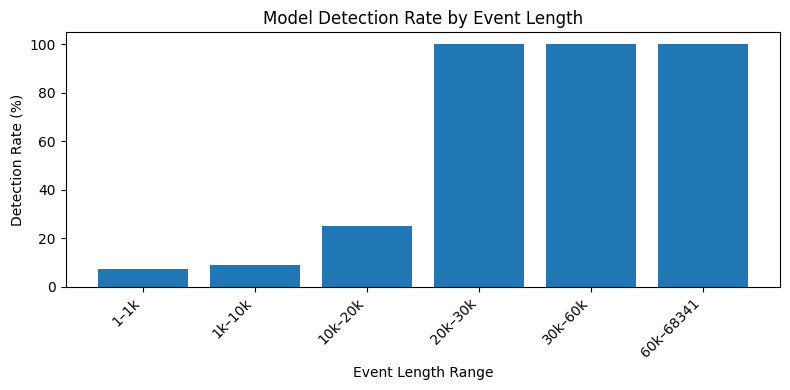

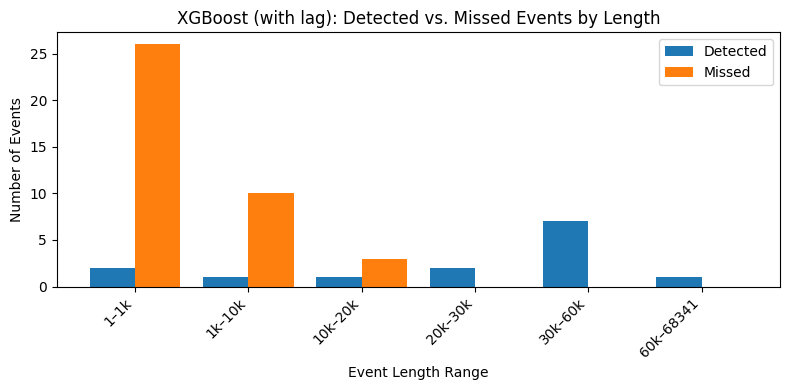

Detected 14 out of 53 events (26.4%).


In [ ]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
import xgboost as xgb
import matplotlib.pyplot as plt


BASE_DIR     = Path("/home/hajjohn1/bachelors-thesis")
TRAIN_PATH   = BASE_DIR / "data" / "train_lag.parquet"     
EVAL_PATH    = BASE_DIR / "data" / "eval_lag.parquet"       
MODEL_PATH   = BASE_DIR / "final" / "XGB" / "lag_corrected" / "run_20250817_124559" / "xgb_model.json"
OUTPUT_DIR   = BASE_DIR / "final" / "XGB" / "lag_corrected"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)


train_df = pd.read_parquet(TRAIN_PATH)
eval_df  = pd.read_parquet(EVAL_PATH)

if "is_anomaly" not in train_df.columns or "is_anomaly" not in eval_df.columns:
    missing_in = []
    if "is_anomaly" not in train_df.columns:
        missing_in.append("train_lag.parquet")
    if "is_anomaly" not in eval_df.columns:
        missing_in.append("eval_lag.parquet")
    raise ValueError(f"Label column 'is_anomaly' missing in: {', '.join(missing_in)}")


train_feature_cols = [c for c in train_df.columns if c != "is_anomaly"]


missing_in_eval = [c for c in train_feature_cols if c not in eval_df.columns]
if missing_in_eval:
    raise ValueError(
        "Evaluation data is missing features seen in training:\n"
        + "\n".join(missing_in_eval)
    )

eval_aligned = eval_df[train_feature_cols].copy()

print(f"Using {len(train_feature_cols)} features (aligned to training):")
print(train_feature_cols[:10] + (["..."] if len(train_feature_cols) > 10 else []))


model = xgb.Booster()
model.load_model(str(MODEL_PATH))


dmatrix = xgb.DMatrix(eval_aligned.values, feature_names=train_feature_cols)
probs   = model.predict(dmatrix)
preds   = (probs >= 0.5).astype(int)


mask = eval_df["is_anomaly"] == 1

event_ids = (mask != mask.shift(fill_value=False)).cumsum()
eval_df["event_id"] = np.where(mask, event_ids, np.nan)

events = []
for eid, group in eval_df[eval_df["event_id"].notna()].groupby("event_id"):
    length   = int(len(group))
    detected = bool(preds[group.index].sum() > 0)
    events.append({
        "event_id": int(eid),
        "length": length,
        "detected": detected
    })

model_name = Path(MODEL_PATH).stem  
out_path   = OUTPUT_DIR / f"eval_event_detection_{model_name}.json"
with open(out_path, "w") as f:
    json.dump({"model": model_name, "events": events}, f, indent=2)

print(f"Saved {len(events)} event detection records to {out_path}")


if len(events) == 0:
    print("No events found in evaluation labels (is_anomaly == 1). Skipping plots.")
else:
    df_events = pd.DataFrame(events)[["length", "detected"]]

    max_len = int(df_events["length"].max())
    bins = [1, 1_000, 10_000, 20_000, 30_000, 60_000, max_len + 1]
    labels = ["1–1k", "1k–10k", "10k–20k", "20k–30k", "30k–60k", f"60k–{max_len}"]

    df_events["length_bin"] = pd.cut(
        df_events["length"],
        bins=bins,
        labels=labels,
        right=False,
        include_lowest=True
    )

    grouped = (
        df_events
        .groupby("length_bin", dropna=False)["detected"]
        .agg(total_events="count", detected_events="sum")
    )

    grouped["detection_rate"] = np.where(
        grouped["total_events"] > 0,
        grouped["detected_events"] / grouped["total_events"] * 100.0,
        0.0
    )


    plt.figure(figsize=(8, 4))
    plt.bar(grouped.index.astype(str), grouped["detection_rate"])
    plt.xlabel("Event Length Range")
    plt.ylabel("Detection Rate (%)")
    plt.title("Model Detection Rate by Event Length")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    undetected = grouped["total_events"] - grouped["detected_events"]
    x = np.arange(len(grouped.index))
    width = 0.4

    plt.figure(figsize=(8, 4))
    plt.bar(x - width/2, grouped["detected_events"], width, label="Detected")
    plt.bar(x + width/2, undetected, width, label="Missed")
    plt.xticks(x, grouped.index.astype(str), rotation=45, ha="right")
    plt.xlabel("Event Length Range")
    plt.ylabel("Number of Events")
    plt.title("XGBoost (with lag): Detected vs. Missed Events by Length")
    plt.legend()
    plt.tight_layout()
    plt.show()

    total_events = len(events)
    detected_count = int(grouped["detected_events"].sum())
    print(f"Detected {detected_count} out of {total_events} events ({detected_count/total_events*100:.1f}%).")


Using 404 features (aligned to training):
['id', 'channel_12', 'channel_14', 'channel_15', 'channel_16', 'channel_18', 'channel_19', 'channel_22', 'channel_26', 'channel_28', '...']
Saved 137 training event detection records to /home/hajjohn1/bachelors-thesis/final/XGB/lag_corrected/train_event_detection_xgb_model.json


/tmp/ipykernel_2116040/979360759.py:104: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("length_bin", dropna=False)["detected"]


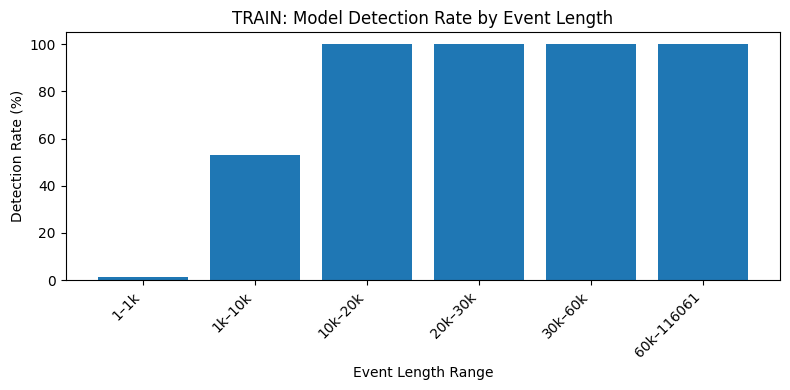

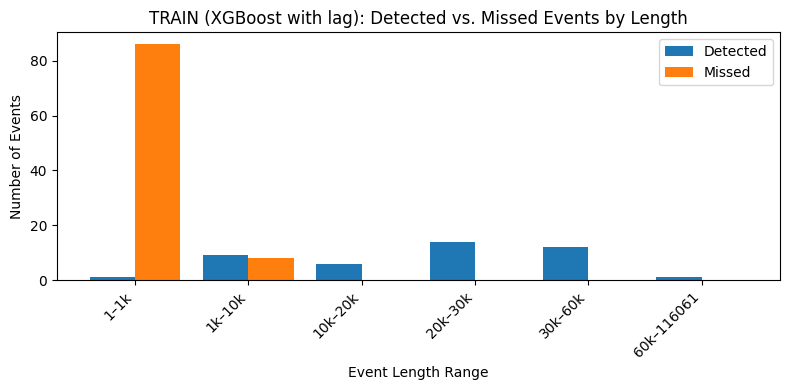

[TRAIN] Detected 43 out of 137 events (31.4%).


In [ ]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
import xgboost as xgb
import matplotlib.pyplot as plt

BASE_DIR     = Path("/home/hajjohn1/bachelors-thesis")
TRAIN_PATH   = BASE_DIR / "data" / "train_lag.parquet"    
MODEL_PATH   = BASE_DIR / "final" / "XGB" / "lag_corrected" / "run_20250817_124559" / "xgb_model.json"
OUTPUT_DIR   = BASE_DIR / "final" / "XGB" / "lag_corrected"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)


train_df = pd.read_parquet(TRAIN_PATH)

if "is_anomaly" not in train_df.columns:
    raise ValueError("Label column 'is_anomaly' missing in train_lag.parquet")


train_feature_cols = [c for c in train_df.columns if c != "is_anomaly"]

print(f"Using {len(train_feature_cols)} features (aligned to training):")
print(train_feature_cols[:10] + (["..."] if len(train_feature_cols) > 10 else []))

model = xgb.Booster()
model.load_model(str(MODEL_PATH))

train_aligned = train_df[train_feature_cols].copy()
dmatrix_train = xgb.DMatrix(train_aligned.values, feature_names=train_feature_cols)
probs_train   = model.predict(dmatrix_train)
preds_train   = (probs_train >= 0.5).astype(int)


mask = train_df["is_anomaly"] == 1

event_ids = (mask != mask.shift(fill_value=False)).cumsum()
train_df["event_id"] = np.where(mask, event_ids, np.nan)

events = []
for eid, group in train_df[train_df["event_id"].notna()].groupby("event_id"):
    length   = int(len(group))

    detected = bool(preds_train[group.index].sum() > 0)
    events.append({
        "event_id": int(eid),
        "length": length,
        "detected": detected
    })


model_name = Path(MODEL_PATH).stem 
out_path   = OUTPUT_DIR / f"train_event_detection_{model_name}.json"
with open(out_path, "w") as f:
    json.dump({"model": model_name, "split": "train", "events": events}, f, indent=2)

print(f"Saved {len(events)} training event detection records to {out_path}")


if len(events) == 0:
    print("No events found in training labels (is_anomaly == 1). Skipping plots.")
else:
    df_events = pd.DataFrame(events)[["length", "detected"]]

    max_len = int(df_events["length"].max())
    bins = [1, 1_000, 10_000, 20_000, 30_000, 60_000, max_len + 1]
    labels = ["1–1k", "1k–10k", "10k–20k", "20k–30k", "30k–60k", f"60k–{max_len}"]

    df_events["length_bin"] = pd.cut(
        df_events["length"],
        bins=bins,
        labels=labels,
        right=False,
        include_lowest=True
    )

    grouped = (
        df_events
        .groupby("length_bin", dropna=False)["detected"]
        .agg(total_events="count", detected_events="sum")
    )
    grouped["detection_rate"] = np.where(
        grouped["total_events"] > 0,
        grouped["detected_events"] / grouped["total_events"] * 100.0,
        0.0
    )


    plt.figure(figsize=(8, 4))
    plt.bar(grouped.index.astype(str), grouped["detection_rate"])
    plt.xlabel("Event Length Range")
    plt.ylabel("Detection Rate (%)")
    plt.title("TRAIN: Model Detection Rate by Event Length")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


    undetected = grouped["total_events"] - grouped["detected_events"]
    x = np.arange(len(grouped.index))
    width = 0.4

    plt.figure(figsize=(8, 4))
    plt.bar(x - width/2, grouped["detected_events"], width, label="Detected")
    plt.bar(x + width/2, undetected, width, label="Missed")
    plt.xticks(x, grouped.index.astype(str), rotation=45, ha="right")
    plt.xlabel("Event Length Range")
    plt.ylabel("Number of Events")
    plt.title("TRAIN (XGBoost with lag): Detected vs. Missed Events by Length")
    plt.legend()
    plt.tight_layout()
    plt.show()

    total_events   = len(events)
    detected_count = int(grouped["detected_events"].sum())
    print(f"[TRAIN] Detected {detected_count} out of {total_events} events "
          f"({detected_count/total_events*100:.1f}%).")
